In [44]:
import os
import cv2
import glob
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from keras.utils import normalize
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from matplotlib.patches import Rectangle
from tensorflow.keras.layers import Layer
from sklearn.metrics import average_precision_score

seed = 42
SIZE_X = 128
SIZE_Y = 128
n_channels = 3
n_classes = 10
Batch_size = 16
EPOCHS = 100
MODEL = 'unet'
activation = 'softmax'
BACKBONE = 'efficientnetb7'
encoder_weights = 'imagenet'
parent_directory = r'E:\Segmentation\datasets\FloodNet-Supervised_v1.0(customized)'

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict()
mask_data_gen_args = dict()

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory(f"{parent_directory}\\train_images", 
                                                           seed=seed, 
                                                           batch_size=Batch_size,
                                                           class_mode=None,
                                                           target_size=(SIZE_X, SIZE_Y)) 

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(f"{parent_directory}\\train_masks", 
                                                         seed=seed, 
                                                         batch_size=Batch_size,
                                                         color_mode = 'grayscale',
                                                         class_mode=None,
                                                         target_size=(SIZE_X, SIZE_Y))


valid_img_generator = image_data_generator.flow_from_directory(f"{parent_directory}\\val_images", 
                                                           seed=seed, 
                                                           batch_size=Batch_size,
                                                           class_mode=None,
                                                           target_size=(SIZE_X, SIZE_Y)) 

valid_mask_generator = mask_data_generator.flow_from_directory(f"{parent_directory}\\val_masks", 
                                                         seed=seed, 
                                                         batch_size=Batch_size,
                                                         color_mode = 'grayscale',
                                                         class_mode=None,
                                                         target_size=(SIZE_X, SIZE_Y))


train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)

Found 1445 images belonging to 1 classes.
Found 1445 images belonging to 1 classes.
Found 450 images belonging to 1 classes.
Found 450 images belonging to 1 classes.


In [46]:
def preprocess_data(images, masks, unet_preporcessing):
    if unet_preporcessing:
        images = unet_preporcessing(images)
    else:
        images = normalize(images, axis=1)
    
    masks = np.expand_dims(masks, axis=-1)
    masks = to_categorical(masks, num_classes=n_classes)
    masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], n_classes))

    return images, masks

In [48]:
from tensorflow.keras.utils import to_categorical

def load_data(image_generator, mask_generator, preprocessing_function=None):
    for (img, mask) in zip(image_generator, mask_generator):
        if preprocessing_function:
            img = preprocessing_function(img)
        mask = to_categorical(mask, num_classes=10)
        yield img, mask

In [49]:
class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}
    
color_map = {'Background':[0, 0, 0], 'Building-flooded':[196, 0, 0], 'Building-non-flooded': [255,128,128], 'Road-flooded':[128, 128, 0],  'Road-non-flooded':[128, 128, 128], 
                 'Water': [0, 191, 255], 'Tree':[34, 139, 34], 'Vehicle': [123, 37, 118],  'Pool':[0, 68, 255],'Grass':[127, 224, 104]}

handles = [Rectangle((0,0),1,1, color = (np.array(c)/255)) for n,c in color_map.items()]

labels = [n for n,c in color_map.items()]


def to_RGB(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """    
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    for key, val in class_map.items():
      label_seg [np.all(label == class_map[key],axis=-1)] = color_map[key]  
    return label_seg

def display_images_with_masks(image, mask, predicted=None):
    if predicted is not None:
      plt.figure(figsize=(12, 8))
    else:
      plt.figure(figsize=(14, 14))
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Testing Label')
    plt.imshow(to_RGB(np.tile(mask, (1, 1, 3))))
    if predicted is not None:
      plt.subplot(133)
      plt.title('Prediction')
      plt.imshow(to_RGB(np.tile(np.expand_dims(predicted, axis=-1), (1, 1, 3))))
    plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
    plt.show()

In [13]:
x_train_batch, y_train_batch = next(train_generator)
x_train_batch.shape, y_train_batch.shape

((16, 128, 128, 3), (16, 128, 128, 1))

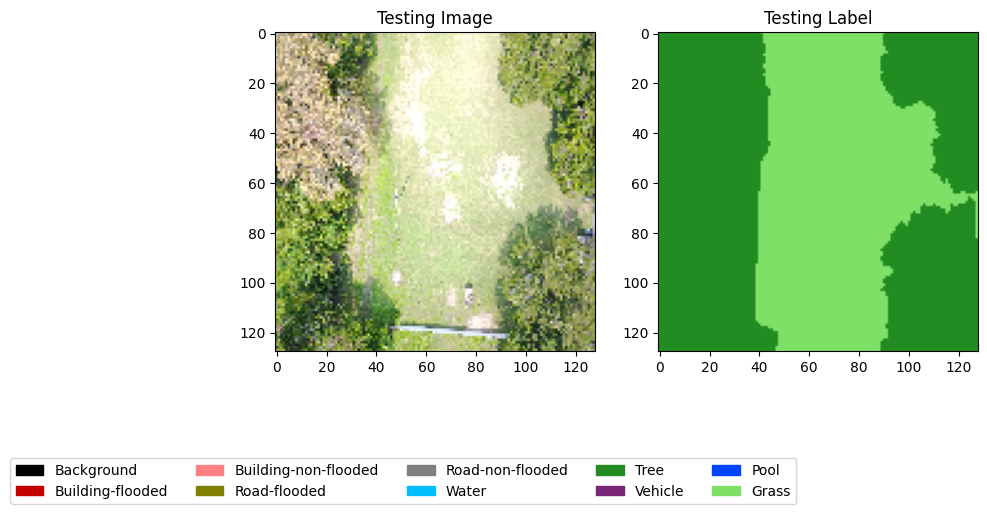

In [14]:
display_images_with_masks(x_train_batch[0], y_train_batch[0])

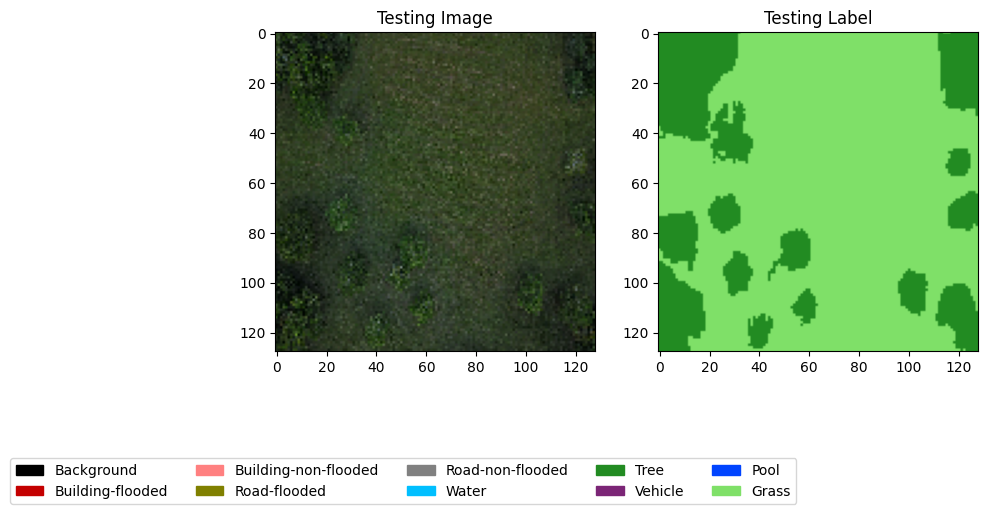

In [15]:
display_images_with_masks(x_train_batch[2], y_train_batch[2])

In [50]:
import segmentation_models as sm

preprocess_input = sm.get_preprocessing(BACKBONE)

train_generator = load_data(image_generator, mask_generator, preprocess_input)
val_generator = load_data(valid_img_generator, valid_mask_generator, preprocess_input)

In [10]:
next(train_generator)[0].shape, next(train_generator)[1].shape

((4, 128, 128, 3), (4, 128, 128, 10))

In [11]:
next(val_generator)[0].shape, next(val_generator)[1].shape

((4, 128, 128, 3), (4, 128, 128, 10))

In [51]:
import segmentation_models as sm

if MODEL == 'unet':
    model = sm.Unet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'fpn':
    model = sm.FPN(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'pspnet':
    model = sm.PSPNet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'linknet':
    model = sm.Linknet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
else:
    raise ValueError('Unknown model')

model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 64, 64)   1728        ['input_2[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 64, 64, 64)   256         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 64, 64, 64)   0           ['stem_bn[0][0]']          

In [52]:
train_samples = len(os.listdir(f"{parent_directory}\\train_images\\train"))
val_samples = len(os.listdir(f"{parent_directory}\\val_images\\val"))
train_samples, val_samples

(1445, 450)

In [53]:
history = model.fit(train_generator, steps_per_epoch=(train_samples // Batch_size), epochs=EPOCHS, validation_data=val_generator, validation_steps=(val_samples // Batch_size),verbose=1)

Epoch 1/100
20/90 [=====>........................] - ETA: 2:46 - loss: 1.5854 - iou_score: 0.0547

In [23]:
model.input_shape

(None, 128, 128, 3)

In [24]:
model.output_shape

(None, 128, 128, 10)

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU-Score')
plt.plot(epochs, val_acc, 'r', label='Validation IOU-Score')
plt.title('Training and validation IOU-Score')
plt.xlabel('Epochs')
plt.ylabel('IOU-Score')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [26]:
test_img_data_gen_args = dict(rescale=1/255.)
test_mask_data_gen_args = dict()

test_image_data_generator = ImageDataGenerator(**test_img_data_gen_args)
test_image_generator = test_image_data_generator.flow_from_directory(f"{parent_directory}\\test_images", 
                                                                     seed=seed, 
                                                                     batch_size=Batch_size,
                                                                     class_mode=None,
                                                                     target_size=(SIZE_X, SIZE_Y)) 

test_mask_data_generator = ImageDataGenerator(**test_mask_data_gen_args)
test_mask_generator = test_mask_data_generator.flow_from_directory(f"{parent_directory}\\test_masks", 
                                                                   seed=seed, 
                                                                   batch_size=Batch_size,
                                                                   color_mode='grayscale',
                                                                   class_mode=None,
                                                                   target_size=(SIZE_X, SIZE_Y))

test_samples = len(os.listdir(f"{parent_directory}\\test_images\\test"))

test_generator = zip(test_image_generator, test_mask_generator)

test_loss, test_accuracy = model.evaluate(test_generator, steps=(test_samples // Batch_size), verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Found 448 images belonging to 1 classes.
Found 448 images belonging to 1 classes.
Test Loss: 43.55586624145508
Test Accuracy: 0.14451727271080017


In [27]:
pickle_file_path = '../dataset/test_data.pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

test_images = loaded_data['test_images']
test_masks = loaded_data['test_masks']
test_images_seperate = loaded_data['test_images_seperate']

test_images, test_masks = preprocess_data(test_images, test_masks, preprocess_input)

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Shapes of loaded data:
Test Images: (448, 128, 128, 3)
Test Masks: (448, 128, 128, 10)


In [28]:
_, acc = model.evaluate(test_images, test_masks, verbose=0)
print("Accuracy is = ", (acc * 100.0), "%")

Accuracy is =  26.078644394874573 %


In [29]:
from keras.metrics import MeanIoU
import numpy as np

y_pred = model.predict(test_images)
predicted_masks = np.argmax(y_pred, axis=-1)
test_masks_ = np.argmax(test_masks, axis=-1)

print(predicted_masks.shape)
print(test_masks_.shape)

14/14 [==============================] - 7s 108ms/step
(448, 128, 128)
(448, 128, 128)


In [30]:
class_names = ["Background", "Building Flooded", "Building Non-Flooded", "Road Flooded", "Road Non-Flooded",
               "Water", "Tree", "Vehicle", "Pool", "Grass"]

n_classes = len(class_names)  
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(test_masks_, predicted_masks)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights())
values = values.reshape(n_classes, n_classes)

class_IoUs = []
print("IoU for each class:")
for i in range(n_classes):
    class_IoU = values[i, i] / (np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i])
    class_IoUs.append(class_IoU)
    print(f"{class_names[i]}: {class_IoU}")

class_APs = []

for i in range(n_classes):
    class_predicted_masks = (predicted_masks == i).astype(int)
    class_test_masks = (test_masks_ == i).astype(int)
    
    class_predicted_masks_flat = class_predicted_masks.flatten().reshape(-1, 1)
    class_test_masks_flat = class_test_masks.flatten().reshape(-1, 1)
    
    class_APs.append(average_precision_score(class_test_masks_flat, class_predicted_masks_flat, average='micro'))

mAP_score = np.mean(class_APs)
print("Overall mAP score =", mAP_score)

Mean IoU = 0.34325528
IoU for each class:
Background: 0.05513426661491394
Building Flooded: 0.17032691836357117
Building Non-Flooded: 0.1771647036075592
Road Flooded: 0.41196781396865845
Road Non-Flooded: 0.7048828601837158
Water: 0.5836557149887085
Tree: 0.5482057929039001
Vehicle: 0.03807850182056427
Pool: 0.0009667543927207589
Grass: 0.7421694397926331
Overall mAP score = 0.3377066976541394


In [31]:
class_names = ["Background", "Building Flooded", "Building Non-Flooded", "Road Flooded", "Road Non-Flooded",
               "Water", "Tree", "Vehicle", "Pool", "Grass"]

n_classes = len(class_names)  
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(test_masks_, predicted_masks)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights())
values = values.reshape(n_classes, n_classes)

class_IoUs = []
print("IoU for each class:")
for i in range(n_classes):
    if i == 0: 
        continue
    class_IoU = values[i, i] / (np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i])
    class_IoUs.append(class_IoU)
    print(f"{class_names[i]}: {class_IoU}")

# Calculate mean IoU excluding background class
mean_IoU_without_background = np.mean(class_IoUs)
print("Mean IoU (excluding Background):", mean_IoU_without_background)

Mean IoU = 0.34325528
IoU for each class:
Building Flooded: 0.17032691836357117
Building Non-Flooded: 0.1771647036075592
Road Flooded: 0.41196781396865845
Road Non-Flooded: 0.7048828601837158
Water: 0.5836557149887085
Tree: 0.5482057929039001
Vehicle: 0.03807850182056427
Pool: 0.0009667543927207589
Grass: 0.7421694397926331
Mean IoU (excluding Background): 0.3752687


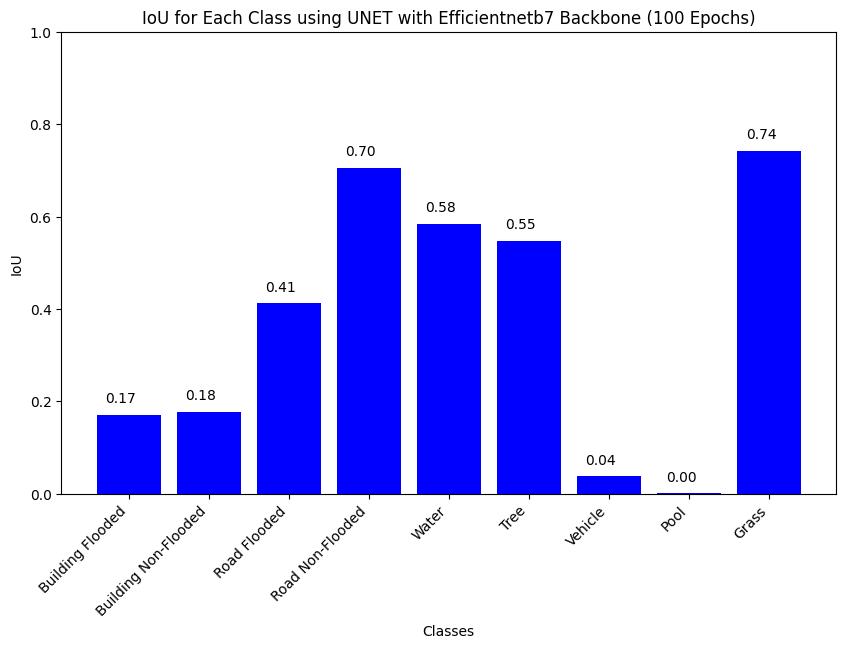

In [32]:
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names[1:], class_IoUs, color='blue')
plt.title(f'IoU for Each Class using {MODEL.upper()} with {BACKBONE.capitalize()} Backbone ({EPOCHS} Epochs)')
plt.xlabel('Classes')
plt.ylabel('IoU')
plt.ylim(0, 1) 
plt.xticks(rotation=45, ha='right')  

for bar, value in zip(bars, class_IoUs):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()

In [33]:
class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}
    
color_map = {'Background':[0, 0, 0], 'Building-flooded':[196, 0, 0], 'Building-non-flooded': [255,128,128], 'Road-flooded':[128, 128, 0],  'Road-non-flooded':[128, 128, 128], 
                 'Water': [0, 191, 255], 'Tree':[34, 139, 34], 'Vehicle': [123, 37, 118],  'Pool':[0, 68, 255],'Grass':[127, 224, 104]}

handles = [Rectangle((0,0),1,1, color = (np.array(c)/255)) for n,c in color_map.items()]

labels = [n for n,c in color_map.items()]


def to_RGB(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """    
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    for key, val in class_map.items():
      label_seg [np.all(label == class_map[key],axis=-1)] = color_map[key]  
    return label_seg

def display_images_with_masks(image, mask, predicted):
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Testing Label')
    plt.imshow(to_RGB(np.tile(np.expand_dims(mask, axis=-1), (1, 1, 3)))) 
    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(to_RGB(np.tile(np.expand_dims(predicted, axis=-1), (1, 1, 3))))
    plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
    plt.show()

In [34]:
def display_random_function():
    image_id = np.random.randint(0, len(test_images))
    image = test_images_seperate[image_id]
    ground_truth_mask = test_masks_[image_id]
    predicted_mask = predicted_masks[image_id]

    print(f'Image Shape: {image.shape}')
    print(f'Ground Truth Mask Shape: {ground_truth_mask.shape}')
    print(f'Predicted Mask Shape: {predicted_mask.shape}')

    display_images_with_masks(image, ground_truth_mask, predicted_mask)

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


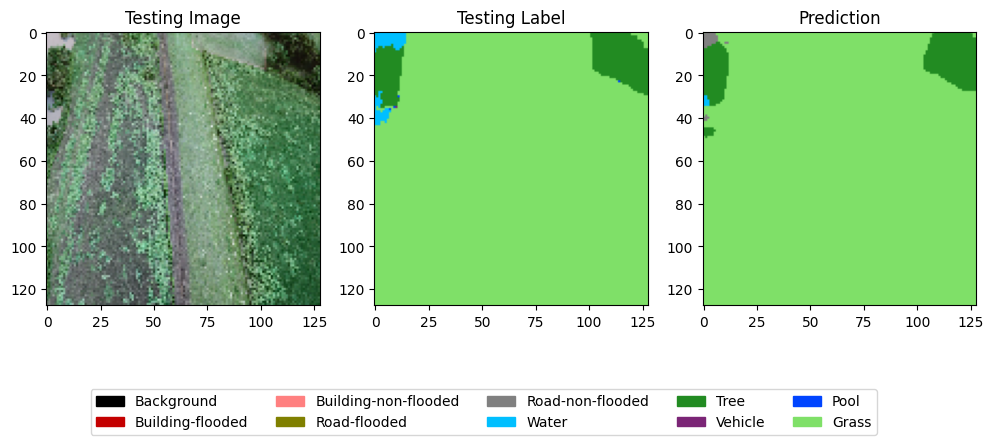

In [35]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


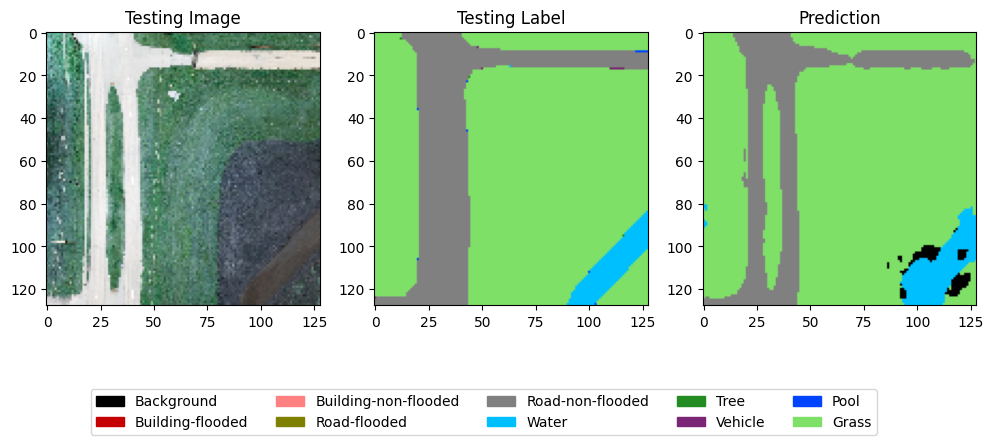

In [36]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


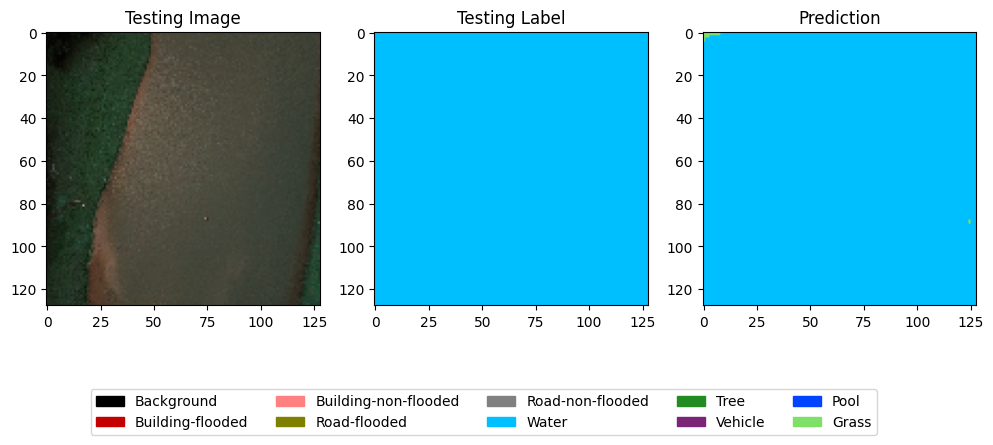

In [37]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


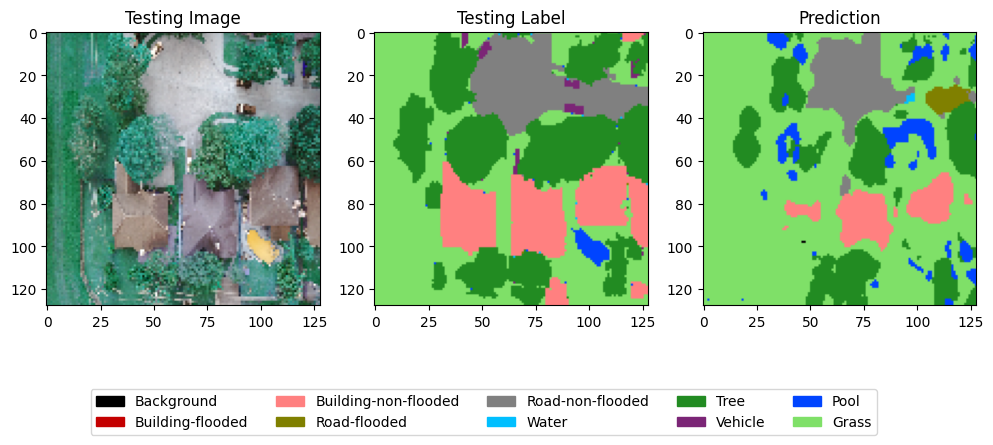

In [38]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


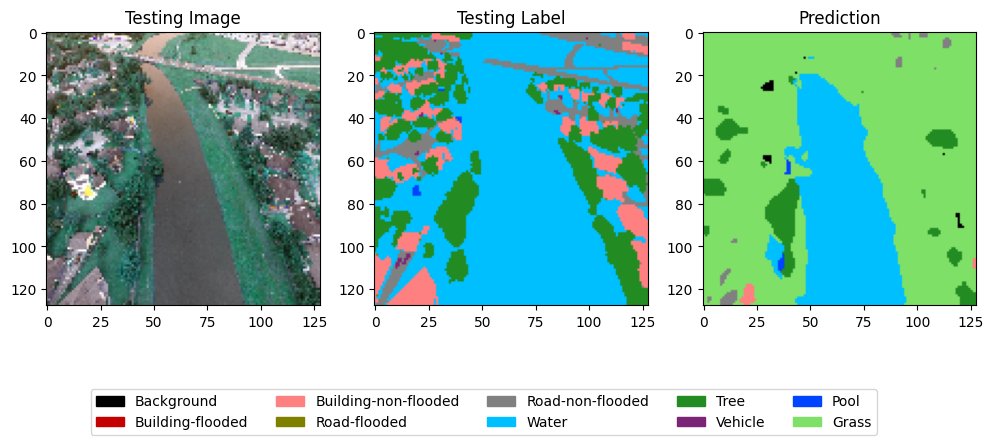

In [43]:
display_random_function()